<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Seminary_UM6P_Jan_2025_Part_1_First_axisymmetric_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

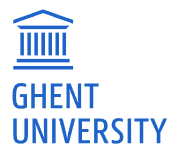<br>


**Axisymmetric Flow in Multilayer Aquifer Systems**<br>
Seminary on Groundwater Modeling<br>
University Mohammed VI Polytechnic<br>
January 6, 2025<br>
Dr. Andy Louwyck

---



---

# **Part 1 - The very first axisymmetric models**

This notebook contains some code examples that illustrate how to implement the Thiem-Dupuit formulas discussed in the first part of the presentation. The explanation provided with each example is relatively concise. If you want to get a good understanding of what's going on, I recommend reading the notebook side by side with the slides. For a full comprehension of the discussed models, I refer to [my PhD thesis](https://github.com/alouwyck/PhD) (Louwyck, 2023).

## 0. Import statements

We need the following libraries:
- [NumPy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. The Thiem-Dupuit equations

The Thiem equation is used to calculate steady-state *confined* one-dimensional axisymmetric flow to a pumping well, while the Dupuit equation is used to calculate steady-state *unconfined* one-dimensional axisymmetric flow to a pumping well. Let's define a function for each equation:

In [2]:
def thiem(r, T, Q, R):
    """
    Calculate drawdown at given distances r according to the Thiem formula for steady confined flow.

    Parameters
    ----------
    r : array_like
      Radial distances [L], which should be smaller than `R`.
    T : float
      Aquifer transmissivity [L²/T].
    Q : float
      Pumping rate [L³/T] of the well.
    R : float
      Radial distance [L] of the outer aquifer boundary.

    Returns
    -------
    s : ndarray
      Drawdown [L] at given distances `r`. The shape of `s` is the same as the shape of `r`.
    """
    r = np.array(r)
    return Q / 2 / np.pi / T * np.log(R / r)

In [3]:
def dupuit(r, K, h0, Q, R):
    """
    Calculate drawdown at given distances r according to the Dupuit formula for steady unconfined flow.

    Parameters
    ----------
    r : array_like
      Radial distances [L], which should be smaller than `R`.
    K : float
      Aquifer conductivity [L/T].
    h0 : float
       Initial hydraulic head [L] which is the initial aquifer thickness before pumping.
       `h0` is also the constant head at the outer aquifer boundary at distance `R`.
    Q : float
      Pumping rate [L³/T] of the well (which is positive in case of extraction).
    R : float
      Radial distance [L] of the outer aquifer boundary.

    Returns
    -------
    s : ndarray
      Drawdown [L] at given distances `r`. The shape of `s` is the same as the shape of `r`.
    """
    return h0 - np.sqrt(h0**2 - Q / np.pi / K * np.log(R / r))

An example to illustrate the use of these functions:

In [4]:
Q  = 1000    # pumping rate (m³/d): Q > 0 -> extraction
R  = 500     # radius of influence (m)
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)

r = np.logspace(-2, np.log10(R), 100)   # radial distances (m)
s1 = dupuit(r=r, Q=Q, K=K, R=R, h0=h0)  # drawdown (m) according to the Dupuit formula
s2 = thiem(r=r, Q=Q, T=T, R=R)          # drawdown (m) according to the Thiem formula

The corresponding plot:

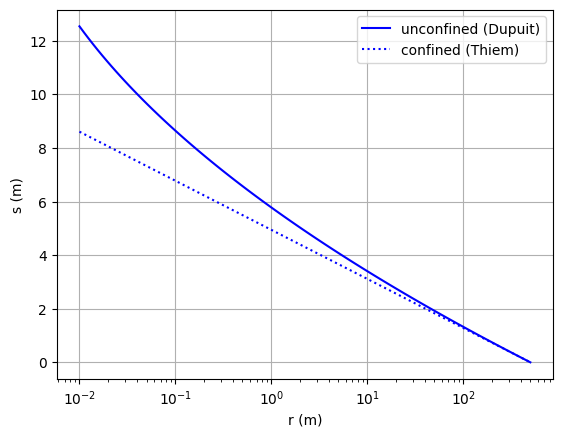

In [5]:
plt.semilogx(r, s1, 'b-', label='unconfined (Dupuit)');  # drawdown s (m) according to the Dupuit formula
plt.semilogx(r, s2, 'b:', label='confined (Thiem)');     # drawdown s (m) according to the Thiem formula
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.legend();
plt.grid();

Although previous semi-logarithmic graph is more practical, it's also possible to visualize the actual cone of depression:

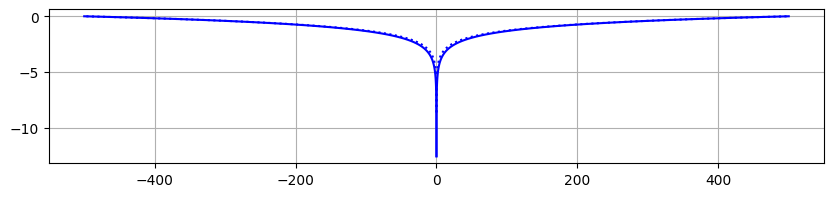

In [6]:
plt.figure(figsize=(10, 2));
plt.plot(-r, -s1, 'b-');
plt.plot(r, -s1, 'b-');
plt.plot(-r, -s2, 'b:');
plt.plot(r, -s2, 'b:');
plt.grid();

## 2. TimML

It is also possible to use TimML to simulate steady flow to a pumping well. [TimML](https://timml.readthedocs.io/en/latest/) is a Python package for the modeling of steady-state multi-layer groundwater flow with analytic elements developed by [Mark Bakker](https://www.tudelft.nl/citg/over-faculteit/afdelingen/watermanagement/medewerker/staff-hydrology/academic-staff/profdrir-mark-bakker), Professor in Groundwater Engineering at the Technical University of Delft in the Netherlands.

First, we need to install TimML:

In [7]:
!pip install timml -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.8 MB/s eta 0:00:00


After installing the TimML package, we import it:

In [8]:
import timml

The first step in a TimML model is to create a model and define the aquifer properties. Here we use the `ModelMaq` class and specify the hydraulic conductivity `kaq`, and the top and bottom of the aquifer, which are assigned to `z`. The `ModelMaq` class returns a `model` object:

In [9]:
model = timml.ModelMaq(
    kaq=K,      # hydraulic conductivity (m/d)
    z=[h0, 0],  # top and bottom of aquifer (m)
)

Once the model is created, we can add analytic elements to the model. Here, we need a `Well` with pumping rate equal to `Q`. To keep it simple, we define the well at (0,0), and set the well radius `rw` to the first radial distance in array `r`:

In [10]:
well = timml.Well(
    model=model,  # model to which element is added
    xw=0,         # x-location of well (m)
    yw=0,         # y-location of well (m)
    Qw=Q,         # discharge of well (m³/d), positive for extraction
    rw=r[0],      # well radius (m), we take the first element of r
)

 Recall that we also have to define a `Constant` head at distance `R`:

In [11]:
constant = timml.Constant(
    model=model,  # model to which element is added
    xr=R,         # x-location of fixed head (m)
    yr=0,         # y-location of fixed head (m)
    hr=h0,        # fixed head (m)
)

Now we're ready to solve the model, which means that any unknown parameters in the model are computed.

In [12]:
model.solve()

Number of elements, Number of equations: 2 , 1
..
solution complete


Calling method `model.head()` gives the head at a specified point (x,y). Drawdown at distances `r` is calculated as the difference between the initial head `h0` and the head during pumping:

In [13]:
s3 = h0 - np.array([model.head(x=r, y=0) for r in r])

This gives virtually the same result as the Thiem solution:

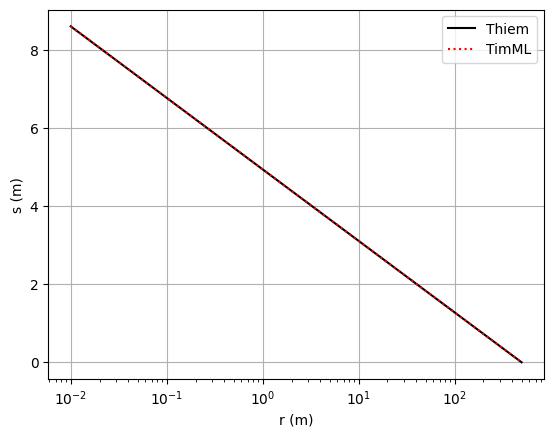

In [14]:
plt.semilogx(r, s2, 'k-', label='Thiem');
plt.semilogx(r, s3, 'r:', label='TimML');
plt.legend();
plt.xlabel('r (m)');
plt.ylabel('s (m)');
plt.grid();

The various steps you need to take with TimML may seem somewhat cumbersome at first glance, but this is because TimML is a generic model for simulating groundwater flow in multilayer aquifer systems. In addition to wells and constant heads, more complex elements can also be added to a model, such as line sinks and areal sinks, which can be used to simulate interactions with rivers and infiltration areas.

Another nice feature of TimML is method `contour`:

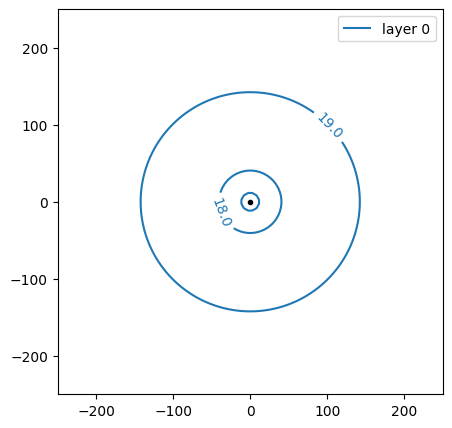

In [15]:
model.contour(
    win=[-R/2, R/2, -R/2, R/2],  # window to contour [xmin, xmax, ymin, ymax]
    ngr=100,                     # number of points where to compute the head
    levels=np.arange(20),        # levels to be contoured
    labels=True,                 # add labels along the contours
    decimals=1,                  # print labels with 1 decimal place
    legend=True,                 # add a legend
    figsize=(5, 5),              # specify a figure size of 5 by 5 inches
);

Check the TimML documentation to see how you can plot pathlines and a capture zone.

Is it possible to simulate a Dupuit model using TimML? The answer is no, because TimML only supports confined layers, or more accurately, horizontal layers with constant thickness and constant hydraulic properties.

---